# L6: Build Your Own RAG Bot

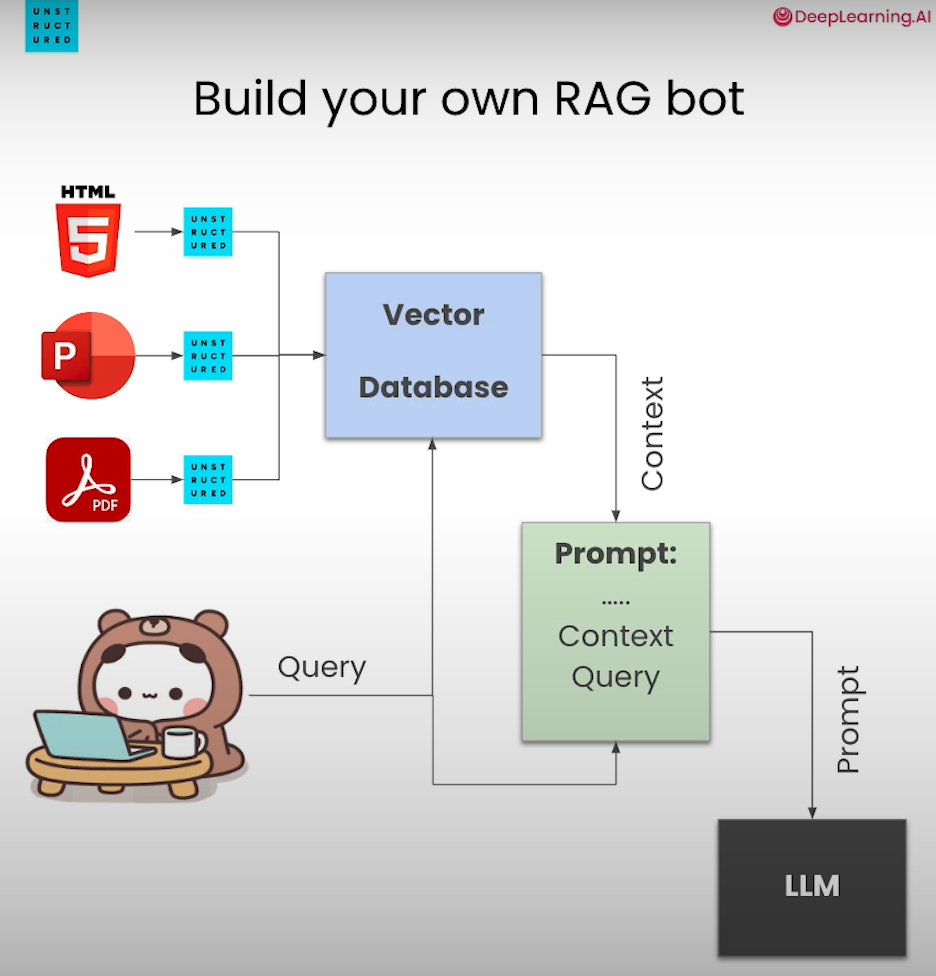

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.chunking.title import chunk_by_title
from unstructured.partition.md import partition_md
from unstructured.partition.pptx import partition_pptx
from unstructured.staging.base import dict_to_elements

import chromadb

In [ ]:
from Utils import Utils
utils = Utils()

DLAI_API_KEY = utils.get_dlai_api_key()
DLAI_API_URL = utils.get_dlai_url()

s = UnstructuredClient(
    api_key_auth=DLAI_API_KEY,
    server_url=DLAI_API_URL,
)

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access helper functions and other related files for this notebook, 1) click on the <em>"View"</em> option on the top menu of the notebook and then 2) click on <em>"File Browser"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


## Example Application: Question Answering about the Donut Model

In [ ]:
from IPython.display import Image
Image(filename='images/donut_paper.png', height=400, width=400)

In [ ]:
Image(filename='images/donut_slide.png', height=400, width=400) 

In [ ]:
Image(filename='images/donut_readme.png', height=600, width=600) 

## Preprocess the PDF

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Wait Time)</code>:</b> The following block can take a few minutes to complete.</p>

In [ ]:
filename = "example_files/donut_paper.pdf"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
    pdf_infer_table_structure=True,
    skip_infer_table_types=[],
)

try:
    resp = s.general.partition(req)
    pdf_elements = dict_to_elements(resp.elements)
except SDKError as e:
    print(e)

In [ ]:
pdf_elements[0].to_dict()

In [ ]:
tables = [el for el in pdf_elements if el.category == "Table"]

In [ ]:
table_html = tables[0].metadata.text_as_html

In [ ]:
from io import StringIO 
from lxml import etree

parser = etree.XMLParser(remove_blank_text=True)
file_obj = StringIO(table_html)
tree = etree.parse(file_obj, parser)
print(etree.tostring(tree, pretty_print=True).decode())

In [ ]:
Image(filename='images/donut_references.png', height=400, width=400) 

In [ ]:
reference_title = [
    el for el in pdf_elements
    if el.text == "References"
    and el.category == "Title"
][0]

In [ ]:
reference_title.to_dict()

In [ ]:
references_id = reference_title.id

In [ ]:
for element in pdf_elements:
    if element.metadata.parent_id == references_id:
        print(element)
        break

In [ ]:
pdf_elements = [el for el in pdf_elements if el.metadata.parent_id != references_id]

### Filter out headers

In [ ]:
Image(filename='images/donut_headers.png', height=400, width=400) 

In [ ]:
headers = [el for el in pdf_elements if el.category == "Header"]

In [ ]:
headers[1].to_dict()

In [ ]:
pdf_elements = [el for el in pdf_elements if el.category != "Header"]

## Preprocess the PowerPoint Slide

In [ ]:
filename = "example_files/donut_slide.pptx"
pptx_elements = partition_pptx(filename=filename)

## Preprocess the README

In [ ]:
filename = "example_files/donut_readme.md"

In [ ]:
md_elements = partition_md(filename=filename)

## Load the Documents into the Vector DB

In [ ]:
elements = chunk_by_title(pdf_elements + pptx_elements + md_elements)

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

In [ ]:
documents = []
for element in elements:
    metadata = element.metadata.to_dict()
    del metadata["languages"]
    metadata["source"] = metadata["filename"]
    documents.append(Document(page_content=element.text, metadata=metadata))

In [ ]:
embeddings = OpenAIEmbeddings()

In [ ]:
vectorstore = Chroma.from_documents(documents, embeddings)

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 6}
)

In [ ]:
from langchain.prompts.prompt import PromptTemplate
from langchain_openai import OpenAI
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

In [ ]:
template = """You are an AI assistant for answering questions about the Donut document understanding model.
You are given the following extracted parts of a long document and a question. Provide a conversational answer.
If you don't know the answer, just say "Hmm, I'm not sure." Don't try to make up an answer.
If the question is not about Donut, politely inform them that you are tuned to only answer questions about Donut.
Question: {question}
=========
{context}
=========
Answer in Markdown:"""
prompt = PromptTemplate(template=template, input_variables=["question", "context"])

In [ ]:
llm = OpenAI(temperature=0)

doc_chain = load_qa_with_sources_chain(llm, chain_type="map_reduce")
question_generator_chain = LLMChain(llm=llm, prompt=prompt)
qa_chain = ConversationalRetrievalChain(
    retriever=retriever,
    question_generator=question_generator_chain,
    combine_docs_chain=doc_chain,
)

In [ ]:
qa_chain.invoke({
    "question": "How does Donut compare to other document understanding models?",
    "chat_history": []
})["answer"]

In [ ]:
filter_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1, "filter": {"source": "donut_readme.md"}}
)

In [ ]:
filter_chain = ConversationalRetrievalChain(
    retriever=filter_retriever,
    question_generator=question_generator_chain,
    combine_docs_chain=doc_chain,
)

In [ ]:
filter_chain.invoke({
    "question": "How do I classify documents with DONUT?",
    "chat_history": [],
    "filter": filter,
})["answer"]

## Work With Your Own Files

In [ ]:
import panel as pn
#import param
from Utils import upld_file
pn.extension()

upld_widget = upld_file()
pn.Row(upld_widget.widget_file_upload)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 🖥 &nbsp; <b>Note:</b> If the file upload interface isn't functioning properly, the issue may be related to your browser version. In such a case, please ensure your browser is updated to the latest version, or try using a different browser.</p>


In [ ]:
!ls ./example_files

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Uploading Your Own File - Method 2:</b> To upload your own files, you can also 1) click on the <em>"View"</em> option on the top menu of the notebook and then 2) click on <em>"File Browser"</em>. Then 3) click on <em>"Upload"</em> button to upload your files. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>